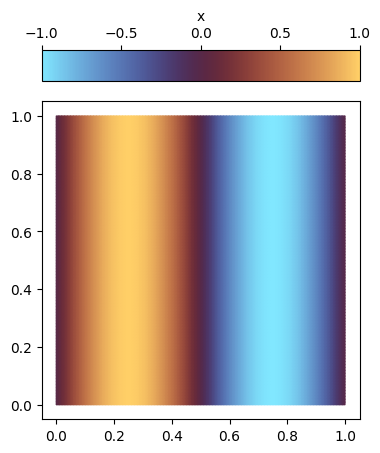

In [1]:
from jax import Array
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from tatva.element import Quad4
from tatva.mesh import ElementType, Mesh
import jax.numpy as jnp
import numpy as np
from tatva import plotting

mesh = Mesh.unit_square(100, 100, type=ElementType.QUAD, dim=2)


# https://stackoverflow.com/questions/52202014/how-can-i-plot-2d-fem-results-using-matplotlib
# def quatplot(coords: Array, quatrangles: Array, ax=None, **kwargs):
#     if not ax:
#         ax = plt.gca()
#     verts = coords[quatrangles]
#     pc = PolyCollection(verts, **kwargs)
#     ax.add_collection(pc)
#     ax.autoscale()
#     return pc


fig, ax = plt.subplots()
ax.set_aspect("equal")

# pc = quatplot(mesh.coords[:, :2], mesh.elements, ax=ax, edgecolor="k", facecolor="none")


# plotting.plot_element_values(mesh, jnp.sin(mesh.coords[:, 0] * 2 * jnp.pi), ax=ax)

# plotting.plot_element_values(
#     mesh.coords, mesh.elements, jnp.sin(mesh.coords[:, 0] * 2 * jnp.pi), ax=ax
# )
plotting.plot_nodal_values(
    *mesh,
    jnp.sin(mesh.coords[:, 0] * 2 * jnp.pi),
    ax=ax,
    edgecolors="k",
    alpha=1,
    label="x",
)

In [ ]:
from tatva import element
from tatva.operator import Operator


mesh = Mesh.rectangle((1, 2), (1, 10), 10, 10, type=ElementType.TRIANGLE, dim=2)
op = Operator(mesh, element.Tri3())
op.integrate(1)

ValueError: Mesh connectivity lists 4 nodes per element but Tri3 expects 3.

In [ ]:
from tatva.compound import Compound, field
from femsolver.operator import Operator


el = Shell4()

op = Operator(mesh, el)
mesh.elements

_el1 = mesh.elements[0]
el1 = mesh.coords[_el1]


class Solution(Compound):
    u = field(shape=(mesh.coords.shape[0], 3))  # 3 dofs per node
    th = field(shape=(mesh.coords.shape[0], 2))  # 2 rotations in local frame


sol = Solution()
sol.arr = sol.arr.at[Solution.u.idx[:, :2]].set(
    jnp.arange(mesh.coords.shape[0] * 2) * 1e-2
)


dNdr = el.shape_function_derivative([0, 0])
J = el.get_jacobian([0, 0], el1)[0]
t1, t2, n, P = el.get_local_frame(J)

el.dNdX([0, 0], el1)
el.directional_derivative([0, 0], el1)

Array([[-1.8940246,  1.8940243,  1.8940246, -1.8940243],
       [-2.0708764, -1.4783674,  2.0708764,  1.4783674]], dtype=float32)

In [3]:
# ----------------
# interpolate kinematics into local tangential frame
# ----------------

u = sol.u[_el1]
th = sol.th[_el1]
J, J_area = el.get_jacobian([0, 0], el1)
frame = el.get_local_frame(J)
frame_basis = jnp.stack((frame.t1, frame.t2, frame.n), axis=0)

N = el.shape_function([0, 0])
Nd = el.directional_derivative([0, 0], el1)
u_gp = (N[:, None] * u).sum(0)
u_gp_local = frame_basis @ u_gp
dudX = u.T @ Nd.T

# directional derivatives in tangential basis
dw = jnp.einsum("ij,i->j", dudX, frame.n)

# rotations about t1, t2
dth = th.T @ Nd.T
# th = (N[:, None] * th).sum(0)


frame_basis, jnp.vstack([*frame[:3]])

(Array([[ 0.9470121 ,  0.        , -0.32119775],
        [ 0.14812727,  0.887311  ,  0.43673515],
        [ 0.2850023 , -0.46117166,  0.84029424]], dtype=float32),
 Array([[ 0.9470121 ,  0.        , -0.32119775],
        [ 0.14812727,  0.887311  ,  0.43673515],
        [ 0.2850023 , -0.46117166,  0.84029424]], dtype=float32))

In [35]:
from femsolver.element.shell import _LocalFrame


def plate_mats(E, nu, h, kappa_s=5 / 6):
    fac = E / (1 - nu**2)
    Cps = fac * jnp.array([[1.0, nu, 0.0], [nu, 1.0, 0.0], [0.0, 0.0, (1 - nu) / 2]])
    A = h * Cps
    D = (h**3 / 12.0) * Cps
    G = E / (2 * (1 + nu))
    Cs = kappa_s * G * h * jnp.eye(2)
    return A, D, Cs


raw_mindlin_shear = dw - th  # [γ1, γ2]

el._mitc4_shear_at_tying_points(el1, sol.u[_el1], sol.th[_el1])
el.mitc4_shear([1, 0], el1, sol.u[_el1], sol.th[_el1])

op.grad(sol.u)[0, 0]

u.T @ el.directional_derivative([0, 0], el1).T


op.element.energy_density_gp([0, 0], el1, u, th)
el.get_membrane_strain([0, 0], el1, u)
el.mitc4_shear([1, 0], el1, u, th)


Array([0.12165035, 0.06239712], dtype=float32)